In [ ]:
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import statsmodels.api as sm

s = json.load( open(os.getenv('PUI2015')+'/fbb_matplotlibrc.json') )
pl.rcParams.update(s)
%pylab inline

pl.rcParams['font.size'] = 20 

I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.


## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [ ]:
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns


reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [ ]:


bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns


#Exploratory phase

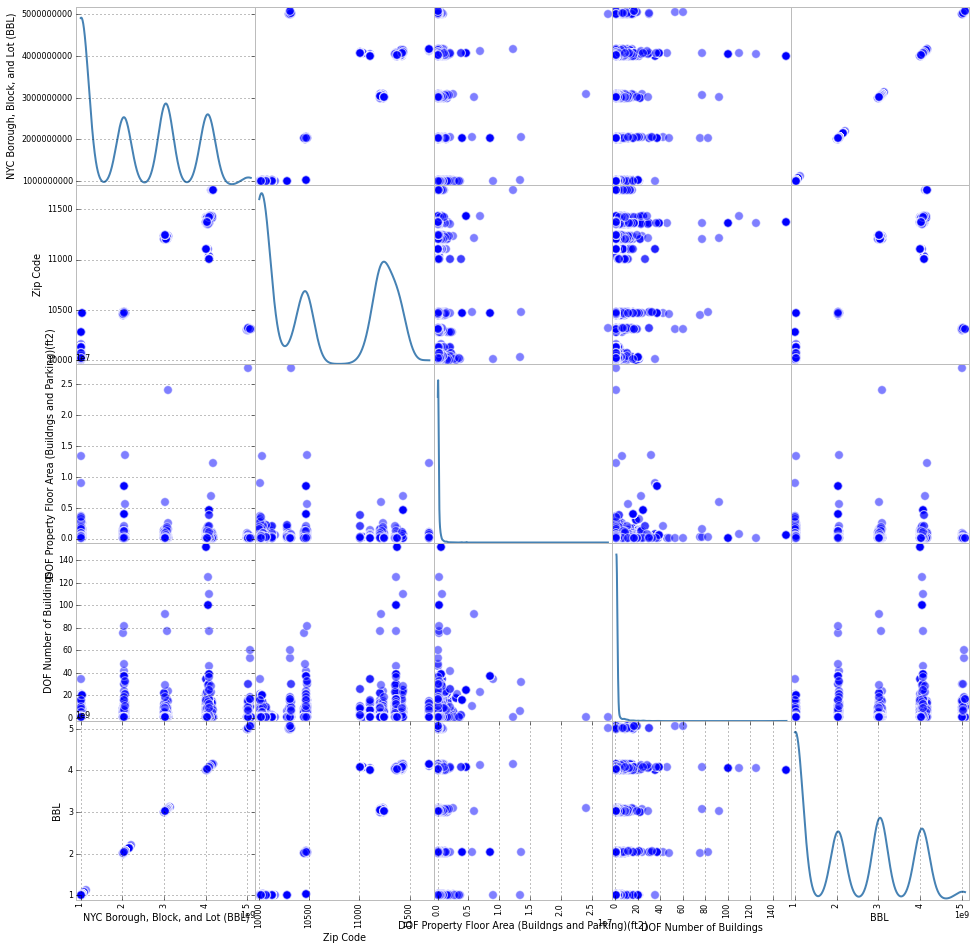

In [13]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

pl.rcParams['font.size'] = 8 

In [14]:
#creating a function to convert spurious values to nan
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False
    

In [15]:

indx=(np.vectorize(canconvert)(nrg['Site EUI(kBtu/ft2)']))
nrg['Site EUI(kBtu/ft2)'][~indx]=float('NaN')

indx=( np.vectorize(canconvert)(nrg['Reported Property Floor Area (Building(s)) (ft²)']))
nrg['Reported Property Floor Area (Building(s)) (ft²)'][~indx]=float('NaN')


/Users/fbianco/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/fbianco/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
#merging data on BBL variable

#renaming the quantity of interest 
#so i can refer to the column as an attribute if i want to 
nrg['BBL'] = nrg['NYC Borough, Block, and Lot (BBL)'] 

bblnrgdata = pd.merge(nrg, bsize, how='inner', on=['BBL'])
print bblnrgdata.columns

Index([                  u'NYC Borough, Block, and Lot (BBL)',
                                    u'Co-reported BBL Status',
                                          u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
                                             u'Street Number',
                                               u'Street Name',
                                                 u'Borough_x',
                                                  u'Zip Code',
                        u'DOF Benchmarking Submission Status',
                                        u'Site EUI(kBtu/ft2)', 
       ...
                                                u'YearAlter2',
                                                 u'YearBuilt',
                                                    u'ZMCode',
                                                   u'ZipCode',
                                                 u'ZoneDist1',
                                           

#VISUALIZING DATA

5344.0
350145188000.0


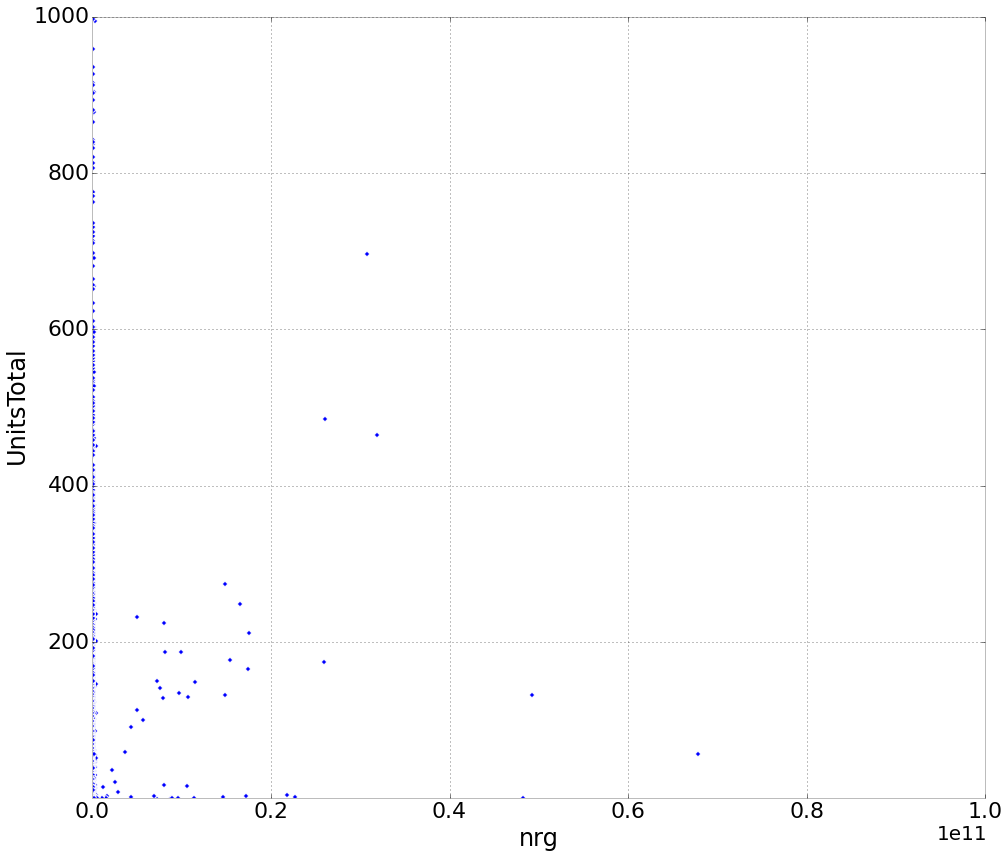

In [17]:
pl.rcParams['font.size'] = 20

bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)*bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
fig = figure(figsize=(15,15))
print bblnrgdata.nrg[bblnrgdata.nrg>0].min()
print bblnrgdata.nrg.max()
'''
indx= s1.UnitsTotal>1000
s1['UnitsTotal'][indx]=float('NaN')
indx= s1.UnitsTotal>1000
s1['UnitsTotal'][indx]=float('NaN')
'''
bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', marker='o', figsize=(16, 14),  xlim=(1000,1e11), ylim=(1,1000), fontsize=22)


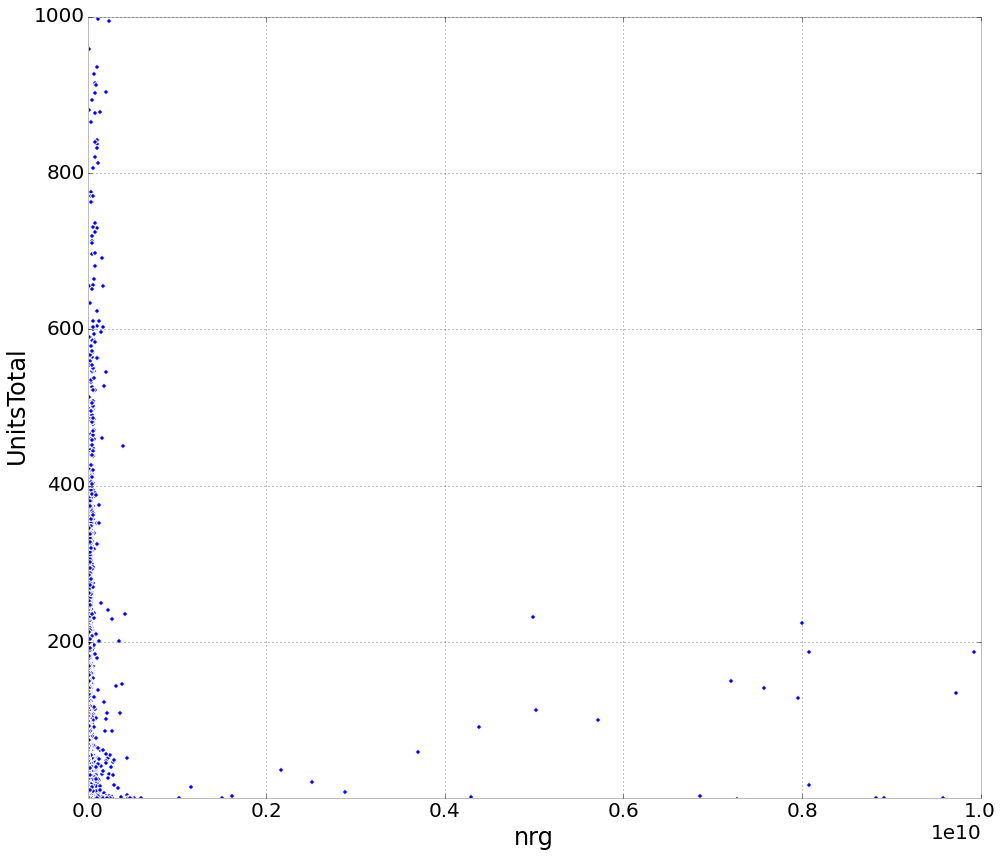

In [18]:
#making sensible cuts on the variable to enhence visibility of the core of the data
pl.rcParams['font.size'] = 20 
bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', marker='o',  figsize=(16, 14),   xlim=(1000,1e10), ylim=(1,1000))


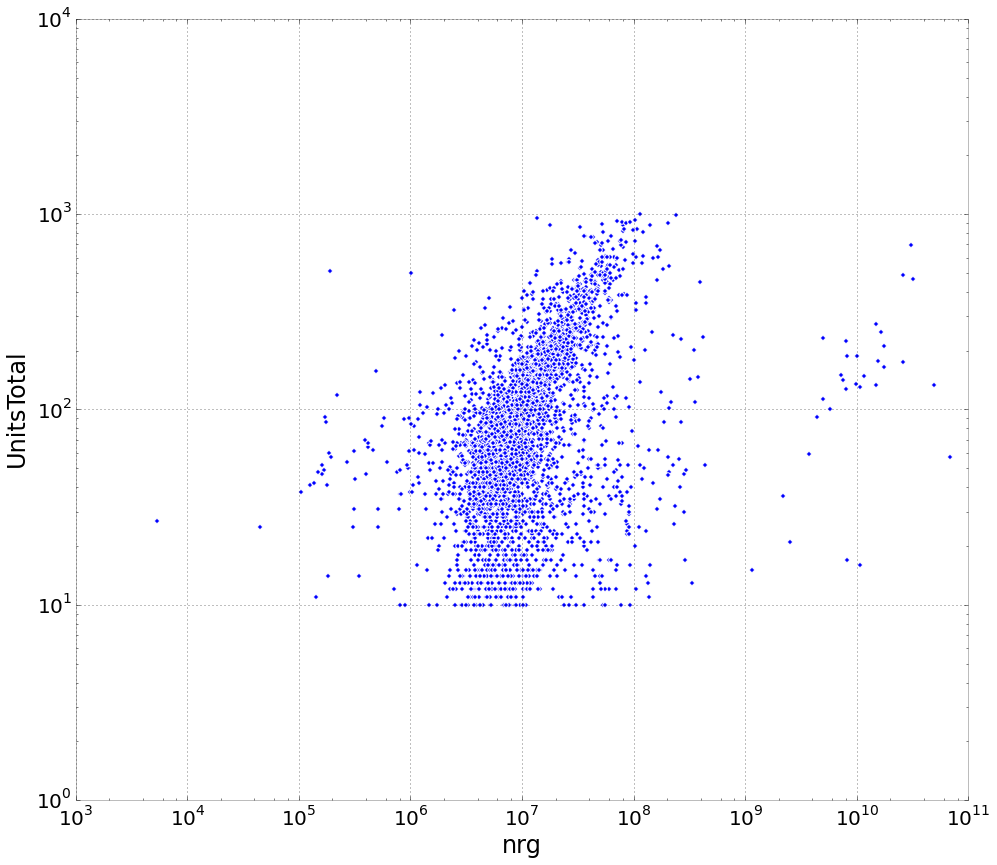

In [19]:
#plotting in log scale to see the spread of the data
#s2= bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.nrg < 1e11) * (s1.UnitsTotal>=10) * (s1.UnitsTotal<1000)]
bblnrgdatacut= bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * (bblnrgdata.UnitsTotal<1000)]

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', marker='o',  figsize=(16, 14), loglog=True, fontsize=20)

Fit data in Log space with a linear regression 
try making a fit for energy vs units AND a fit for units vs energy. 

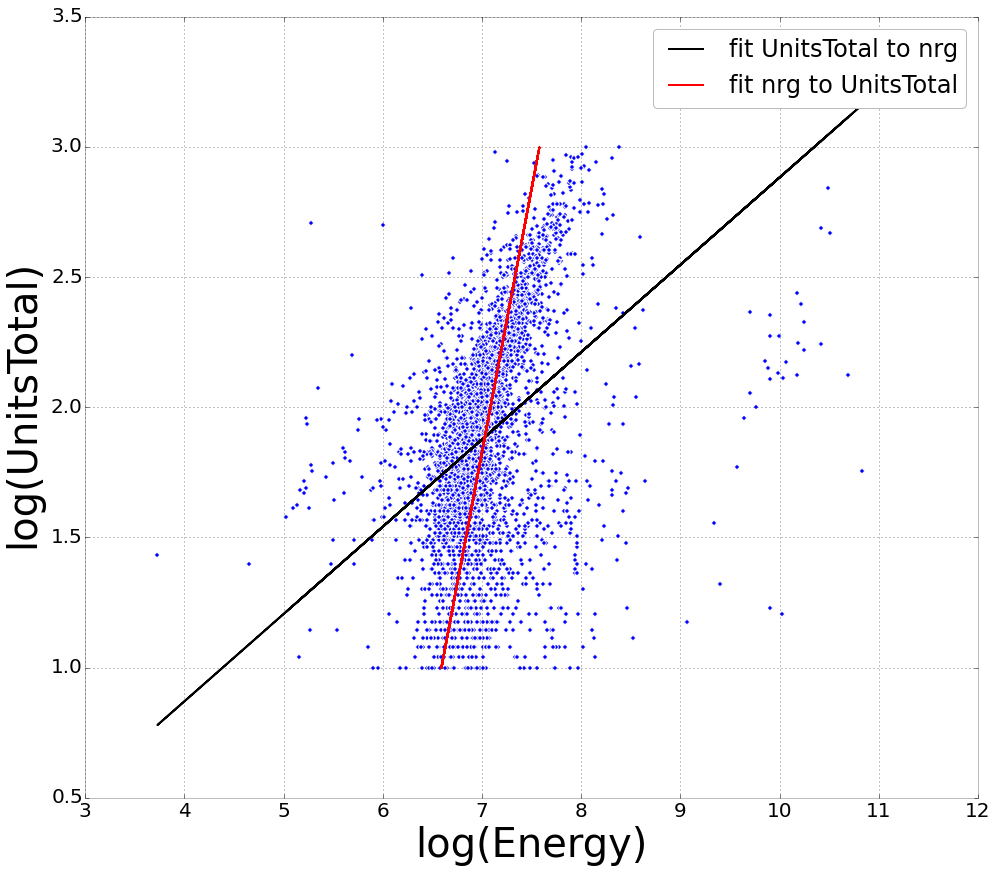

In [24]:
#fit and plots here


X = sm.add_constant(np.log10(bblnrgdatacut.nrg))
fit0 = sm.OLS(np.log10(bblnrgdatacut.UnitsTotal), X, missing='drop').fit() # ignores entires where x or y is NaN

p1,p0= fit0.params[1], fit0.params[0]


pl.figure(figsize=(16, 14))

pl.scatter(np.log10(bblnrgdatacut.nrg), np.log10(bblnrgdatacut.UnitsTotal))
plot(np.log10(bblnrgdatacut.nrg), fit0.predict(), 'k', label="fit UnitsTotal to nrg")
pl.xlabel("log(Energy)", fontsize=40)
pl.ylabel("log(UnitsTotal)", fontsize=40)

X = sm.add_constant(np.log10(bblnrgdatacut.UnitsTotal))
fit1 = sm.OLS(np.log10(bblnrgdatacut.nrg), X, missing='drop').fit() # ignores entires where x or y is NaN

p1,p0= fit1.params[1], fit1.params[0]
#pl.figure(figsize=(16, 14))
#pl.scatter(np.log10(bblnrgdatacut.UnitsTotal), np.log10(bblnrgdatacut.nrg))
plot(fit1.predict(), np.log10(bblnrgdatacut.UnitsTotal), 'r', label="fit nrg to UnitsTotal")
pl.legend()

In [25]:
fit0.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     841.4
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          6.57e-169
Time:                        11:01:22   Log-Likelihood:                -1723.9
No. Observations:                4238   AIC:                             3452.
Df Residuals:                    4236   BIC:                             3465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4706      0.081     -5.778      0.000        -0.630    -0.311
nrg            0.3353      0.012     29.007      0.000         0.313     0.358
==============================================================================
Omnibus:                      168.322   Durbin-Watson:                   1.362
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.893
Skew:                          -0.494   Prob(JB):                     9.60e-42
Kurtosis:                       3.304   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     841.4
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          6.57e-169
Time:                        11:01:23   Log-Likelihood:                -2546.3
No. Observations:                4238   AIC:                             5097.
Df Residuals:                    4236   BIC:                             5109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.0968      0.033    185.618      0.000         6.032     6.161
UnitsTotal     0.4943      0.017     29.007      0.000         0.461     0.528
==============================================================================
Omnibus:                     2285.610   Durbin-Watson:                   1.668
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45896.861
Skew:                           2.131   Prob(JB):                         0.00
Kurtosis:                      18.549   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""



##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

#ANSWER
##the fit that uses number of Units as independent variable is clearly better. That is because the UnitsTotals  data spans the range of values more uniformly than the nrg variable. 

##The fact that the fit is better can be seen by a larger likelihood, however a likelihood test CANNOT be performed. I see 2 reasons for that: 

#1) technical: the likelihood range requires the difference in the degrees of freedom between the variables to be >1 in order to compare its result with the chi square distribution

#2) intellectual: we want to only compare regressions on the same variable!

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     625.4
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          1.03e-238
Time:                        11:01:30   Log-Likelihood:                -5916.5
No. Observations:                4238   AIC:                         1.184e+04
Df Residuals:                    4235   BIC:                         1.186e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       18.5817      0.256     72.498   

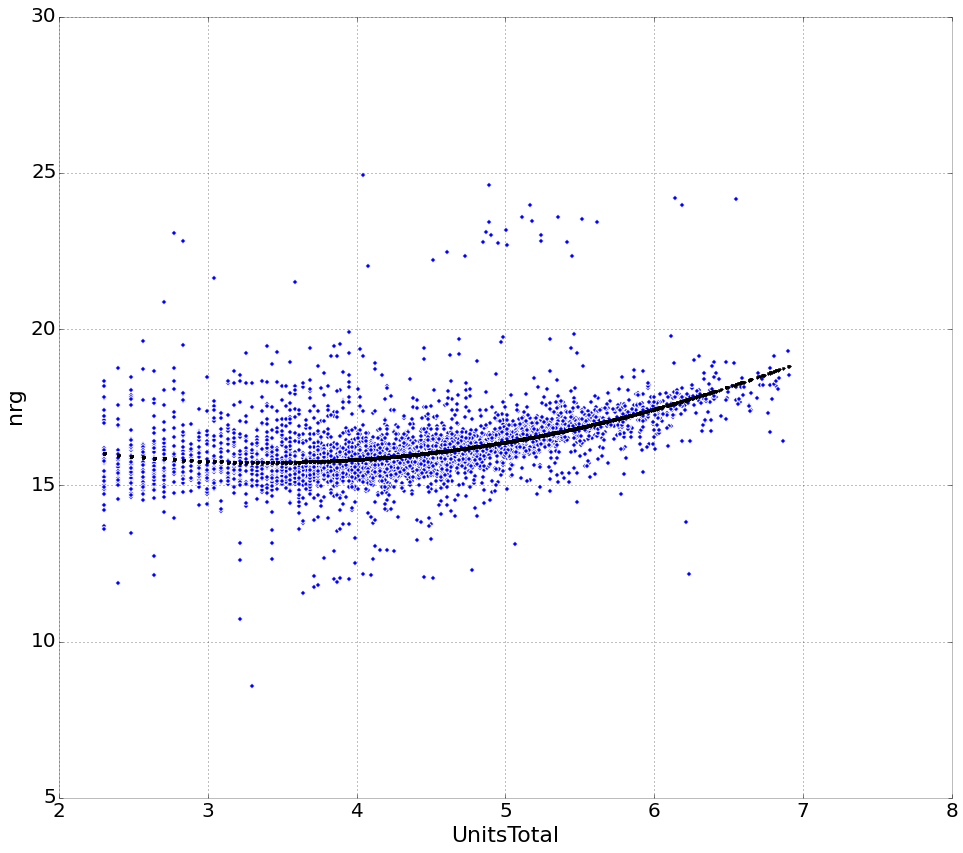

In [27]:
#fit a second degree curve to it: ax^2+bx+c.
import statsmodels.formula.api as smf

curvemodel = smf.ols(formula = "y ~ x1 + I((x1)) + I((x1)**2) ", 
        data={'x1':np.log(bblnrgdatacut.UnitsTotal),'y': np.log(bblnrgdatacut.nrg)}).fit()
print curvemodel.summary()

pl.figure(figsize=(16, 14))
pl.scatter(np.log(bblnrgdatacut.UnitsTotal), np.log(bblnrgdatacut.nrg))
pl.xlabel("UnitsTotal", fontsize=22)
pl.ylabel("nrg", fontsize=22)
plot(np.log(bblnrgdatacut.UnitsTotal), curvemodel.predict(), 'k.')
#print -2598.2

In [30]:
curvemodel.compare_lr_test(fit1)

#the p-value is the second number returned by statsmodels.ols compare_lr_test 


(-6740.3705906790738, 1.0, 1.0)

##from the curvemodel.compare_lr_test i get a p-value of 1. 
##so it looks like i can reject the null to a p value of 1! 
##but this output is a bit tricky to parse for me so i want to convince myself of what it actually means
##i am doing the test by hand:
#HERE IS MORE READING ON LIKELIHOOD RATIO TEST:
https://evomics.org/resources/likelihood-ratio-test/
    

In [31]:
print "LR : ", -2 * (-fit1.llf - (-curvemodel.llf))

LR :  6740.37059068


#COMMENTS:
##note: the null model (the simple one) is at the numerator. since the likelihood 
##is bound to increaase with a lerger number of degrees of freedom that loglikelihood 
##will be smaller, and its negative will be larger (sorry it gets tricky with signs here... 
##not my fault  -loglikelihood is what you want!)

#difference in parameters = chi2 DOF = 1
#the critical value for chi2 with 1 degree of freedom at alpha = 0.05 is 3.84

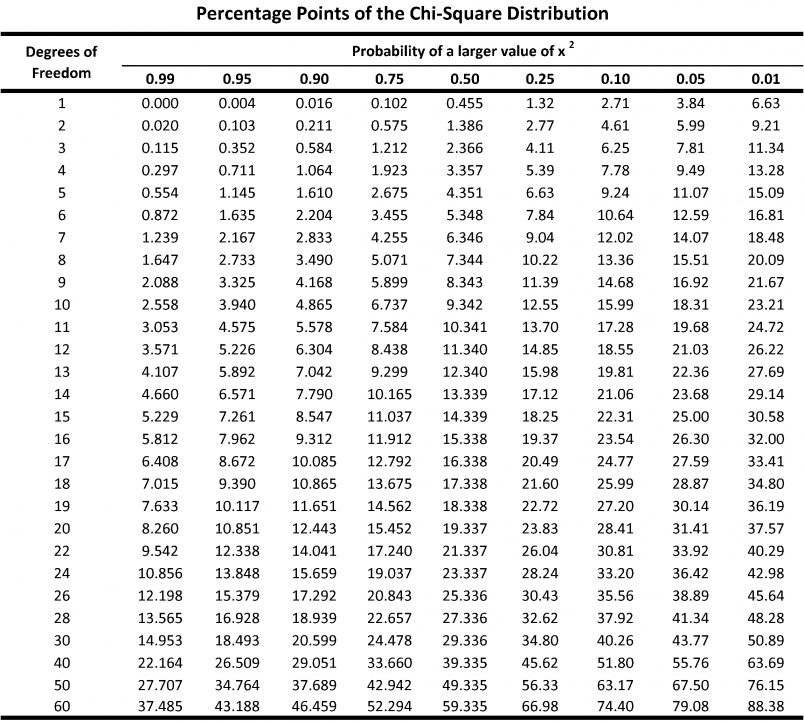

In [44]:
from IPython.display import Image
Image("http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG")

this likelihood ratio is a really really large number! indicating my curve fit is definitely better then my linear fit

Formally: 
H0: line fit is better then 2 deg polynomial fit
H1: line fit is worse than the 2 deg polynomial fit

DEGREES OF FREEDOM: 1 (the curve fit has 1 extra parameter, so 1 more degree of freedom compared to the line fit)

the chisq value for a 1 degree of freedom chisq distribution at apha = 0.05 is 3.84

the probability of our D is far smaller then 0.05, so we can comfortably reject the Null that the line is a better fit

this implies that a 2 parameter model is BETTER, and the addition of the parameters is justified: we are NOT overfitting our data

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

const         6.107179
UnitsTotal    0.495928
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.161
Model:                            WLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     810.9
Date:                Tue, 20 Oct 2015   Prob (F-statistic):          2.31e-163
Time:                        11:04:44   Log-Likelihood:                -2665.1
No. Observations:                4238   AIC:                             5334.
Df Residuals:                    4236   BIC:                             5347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          6.1072      0.034    181.366      0.000         6.041     6.173
UnitsTotal     0.4959      0.017     28.477      0.000         0.462     0.530
==============================================================================
Omnibus:                     2754.498   Durbin-Watson:                   1.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67665.988
Skew:                           2.706   Prob(JB):                         0.00
Kurtosis:                      21.812   Cond. No.                         11.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

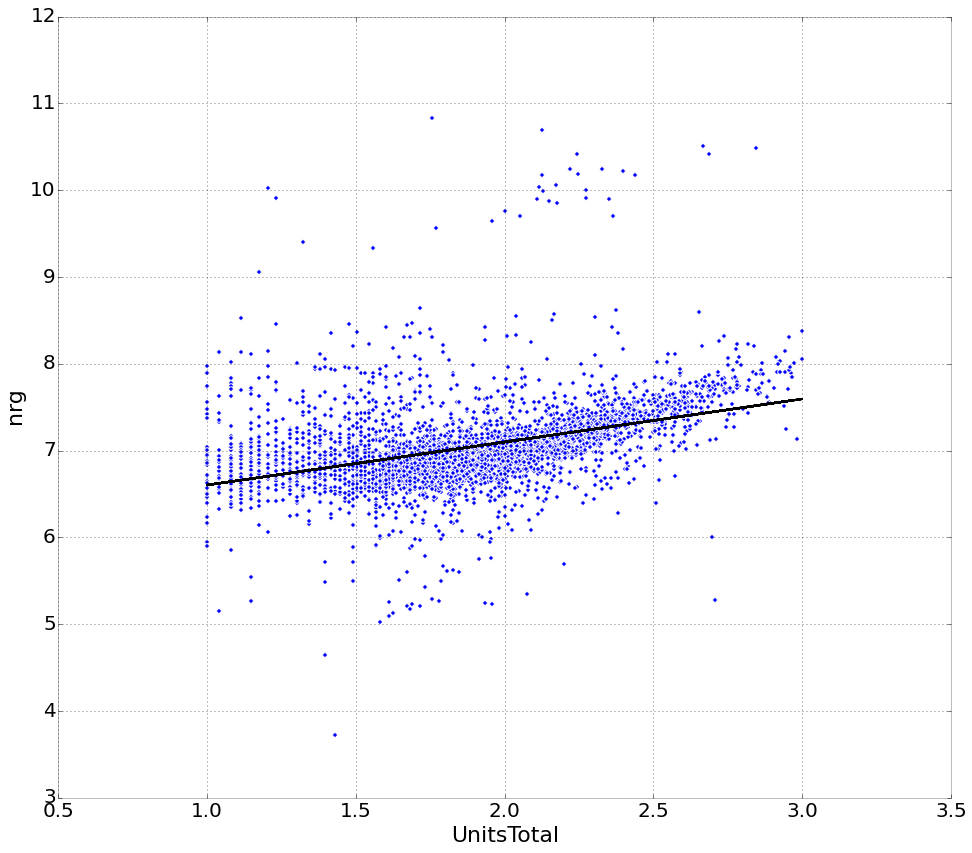

In [45]:
def fit_line2( x, y):
    """Return slope, intercept of best fit line."""
    #print x
    X = sm.add_constant(x)
    #print X
    model = sm.WLS(y, X, np.sqrt(y), missing='drop') # ignores entires where x or y is NaN
    fit = model.fit()
    print fit.params
    return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse
p1,p0,fit2 = fit_line2(np.log10(bblnrgdatacut.UnitsTotal),np.log10(bblnrgdatacut.nrg))
pl.figure(figsize=(16, 14))
pl.scatter(np.log10(bblnrgdatacut.UnitsTotal), np.log10(bblnrgdatacut.nrg))
pl.xlabel("UnitsTotal", fontsize=22)
pl.ylabel("nrg", fontsize=22)
pl.plot(np.log10(bblnrgdatacut.UnitsTotal), fit2.predict(),'k')
#plot(s2.nrg, s2.nrg*p1+p0)
fit2.summary()



In [46]:
print 'the parameters for Ordinary Least Sq fit are {0:2f} {1:2f} '.format(fit1.params[0], fit1.params[1] )
print 'the parameters for Weighted Least sq fit are {0:2f} {1:2f} '.format(fit2.params[0], fit2.params[1])

the parameters for Ordinary Least Sq fit are 6.096813 0.494264 
the parameters for Weighted Least sq fit are 6.107179 0.495928 



the OLS and WLS fit parameters that used the square root of the energy as error (assuming a gaussian or poissonian distribution and no additional sourced of error) are nearly identical. 

In [47]:
##remove
def residuals(model,data,error):
       return np.nansum(((data-model)/error)**2)

Lsurface = np.ones((200,200))*float('NaN')
indxs = np.ones((200,200,2))
for i,l in enumerate(np.arange (-100, 100, 1)):
    #print i 
    for j,k in enumerate(np.arange(-50.0, 50.0, 0.5)):
        #print j
        indxs[i,j]=(l,k)
        Lsurface[i,j]=residuals(np.log(bblnrgdatacut.nrg), np.log(bblnrgdatacut.UnitsTotal)*k+l,  np.sqrt(np.log(bblnrgdatacut.nrg)))
        #print resids[i,j]]

<matplotlib.colorbar.Colorbar instance at 0x1184c0830>

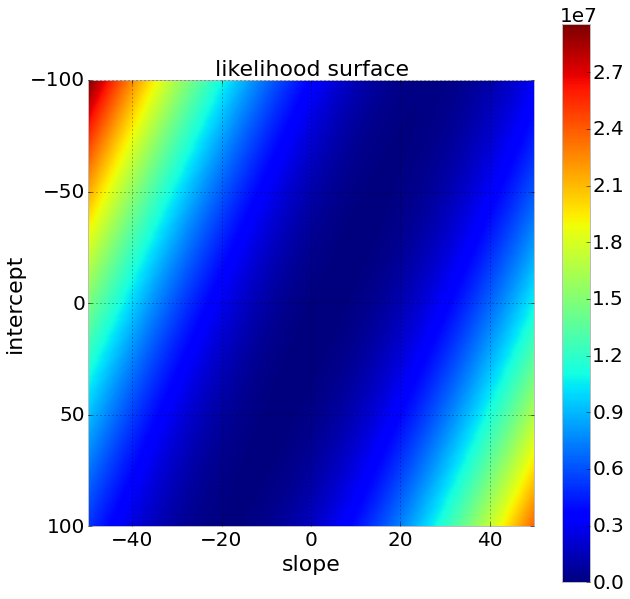

In [48]:
pl.figure(figsize=(10,10))
pl.title ("likelihood surface", fontsize = 22)
pl.imshow(Lsurface, extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x114351ea8>

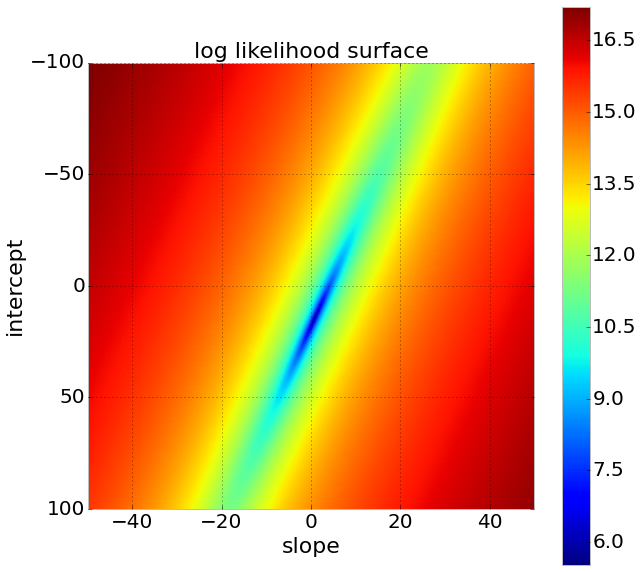

In [49]:
#print resids[~np.isnan(resids)].min(), indxs[np.where(resids==resids[~np.isnan(resids)].min())], np.where(resids==resids[~np.isnan(resids)].min())
#print residuals( fit2.predict(),np.log(s2.nrg),np.sqrt(np.log(s2.nrg)))
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

in log space it is far easier to see the shape of the surface as its minimum at the fit values is sharper

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




/Users/fbianco/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


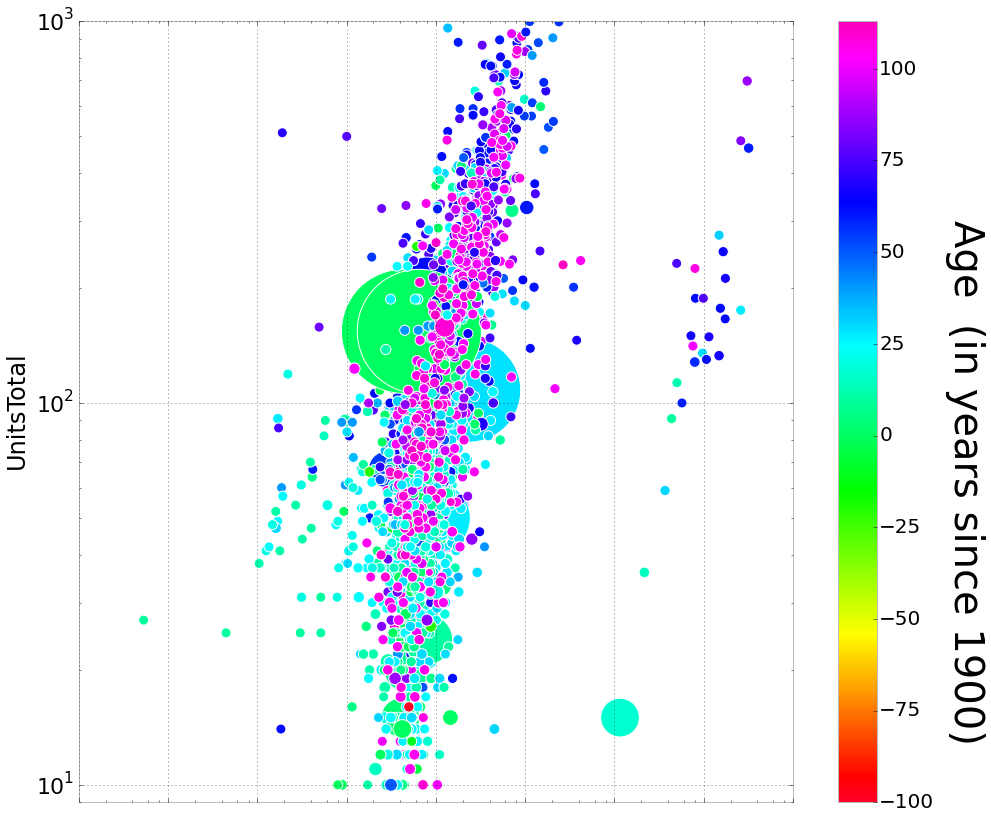

In [50]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(9,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)
pl.text(5e12, 250, 'Age  (in years since 1900)', rotation=270, fontsize=40)

#Caption:
##Number of Building Units plotted against the building energy usage. The color represent the year of construction (years to or since 1900). The size of each datapoint represents the ratio of the total to residential units, and it could therefore be a better metric of occupancy. The size is defined as the ratio of  Total to Residential units (scaled by a factor 100 for visibility) and therefore a larger datapoint indicated a smaller fraction of residential units in the building. The ratio of residential to total units does not appear from this plot to have a significant trend. note however that the range of sized is dominated by a few larger non-residential buildings. 
##The color shows a weak trend: the number of units clearly increases with the decrease of the building age (bottom to top), but there is no clear left-right trend which would indicate a significant decrease or increase f efficiency per unit (where top left could be interpreted as is high efficiency - high number of units, low energy, and bottom right as low efficiency: high energy consumption, few units). 